### _in silico_ perturbation by cell type prompting

In [2]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

DEVICE = torch.device('cuda:0')

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext, \
    GeneNetworkAnalysisBase

In [3]:
ROOT_PATH = "/home/mehrtash/data"
CHECKPOINT_PATH = "/home/mehrtash/data/100M_long_run/run_001/lightning_logs/version_3/checkpoints/epoch=5-step=504000.ckpt"
REF_ADATA_PATH = os.path.join(ROOT_PATH, "data", "extract_0.h5ad")
GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_PATH,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient",
    verbose=False
)

In [77]:
# arguments
query_gene_ids = ctx.model_var_names
assay = "10x 3' v2"
suspension_type = "cell"
prompt_metadata_dict = {
    # "cell_type": "CD8-positive, alpha-beta T cell",
    # "tissue": "blood"
    "cell_type": "enterocyte",
    "tissue": "small intestine",
    "disease": "normal",
    "sex": "male",
}
total_mrna_umis = 10_000

### Gene expression dynamic range determination

In [1]:
query_chunk_size = 1_000
upper_percentile = 0.5
max_counts = 2000
upper_pad = 1

gex_range_dict = ctx.predict_gene_expression_range_for_metadata(
    assay=assay,
    suspension_type=suspension_type,
    prompt_metadata_dict=prompt_metadata_dict,
    total_mrna_umis=total_mrna_umis,
    query_gene_ids=query_gene_ids,
    query_chunk_size=query_chunk_size,
    total_prob_mass=upper_percentile,
    symmetric_range_pad=upper_pad,
    max_counts=max_counts,
)

NameError: name 'ctx' is not defined

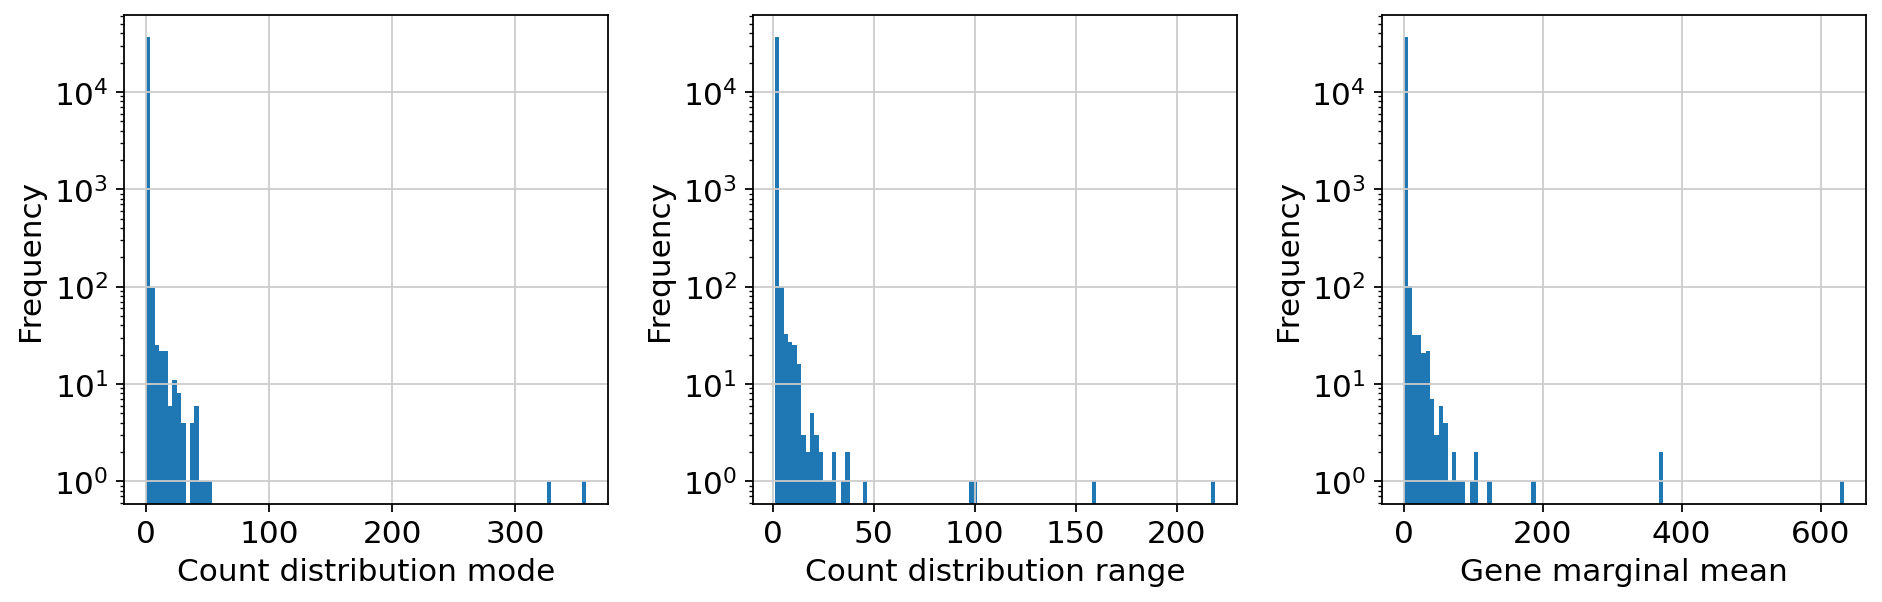

In [79]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax = axs[0]
ax.hist(gex_range_dict['gene_logits_mode_q'].cpu().numpy(), bins=100, log=True);
ax.set_xlabel("Count distribution mode");
ax.set_ylabel("Frequency");

ax = axs[1]
ax.hist(gex_range_dict['range_q'].cpu().numpy(), bins=100, log=True);
ax.set_xlabel("Count distribution range");
ax.set_ylabel("Frequency");

ax = axs[2]
ax.hist(gex_range_dict['gene_marginal_mean_q'].cpu().numpy(), bins=100, log=True);
ax.set_xlabel("Gene marginal mean");
ax.set_ylabel("Frequency");

fig.tight_layout()

In [80]:
# print gene symbols for top 10 genes in terms of mode
top_k = 50
top_k_genes = sorted(
    zip(query_gene_ids,
        gex_range_dict['gene_logits_mode_q'].cpu().numpy(),
        gex_range_dict['gene_marginal_mean_q'].cpu().numpy()), key=lambda x: x[2], reverse=True)[:top_k]
for gene_id, mode, mean in top_k_genes:
    print(f'{ctx.gene_id_to_gene_symbol_map[gene_id]}, mode: {mode}, mean: {mean:.2f}')

MT-CO1, mode: 326, mean: 633.77
MALAT1, mode: 358, mean: 372.83
MT-CO3, mode: 48, mean: 369.51
MT-CO2, mode: 42, mean: 185.53
REG1A, mode: 0, mean: 125.15
MT-ND4, mode: 41, mean: 104.30
PHGR1, mode: 30, mean: 101.71
FTL, mode: 13, mean: 95.48
APOA1, mode: 1, mean: 86.11
FABP1, mode: 19, mean: 79.31
MT-CYB, mode: 42, mean: 74.11
RBP2, mode: 0, mean: 73.09
MT-ATP6, mode: 42, mean: 65.29
MT1G, mode: 3, mean: 63.27
IGHA1, mode: 0, mean: 61.11
APOA4, mode: 0, mean: 60.56
RPL41, mode: 53, mean: 60.10
FTH1, mode: 27, mean: 55.72
MT-ND2, mode: 27, mean: 54.30
EEF1A1, mode: 39, mean: 54.29
RPS18, mode: 42, mean: 53.53
MT-ND3, mode: 24, mean: 52.77
MT-ND1, mode: 27, mean: 50.85
RPL10, mode: 45, mean: 49.26
RPL13A, mode: 41, mean: 46.61
RPLP1, mode: 38, mean: 45.75
RPL13, mode: 39, mean: 43.89
TPT1, mode: 39, mean: 43.08
FABP6, mode: 0, mean: 42.95
B2M, mode: 29, mean: 42.67
RPL34, mode: 31, mean: 42.43
TMSB4X, mode: 13, mean: 41.61
RPS14, mode: 31, mean: 38.93
RPS12, mode: 27, mean: 36.99
RPS6, 

mode: 10, range: 6
lo: 4, hi: 16


Text(0, 0.5, 'Probability')

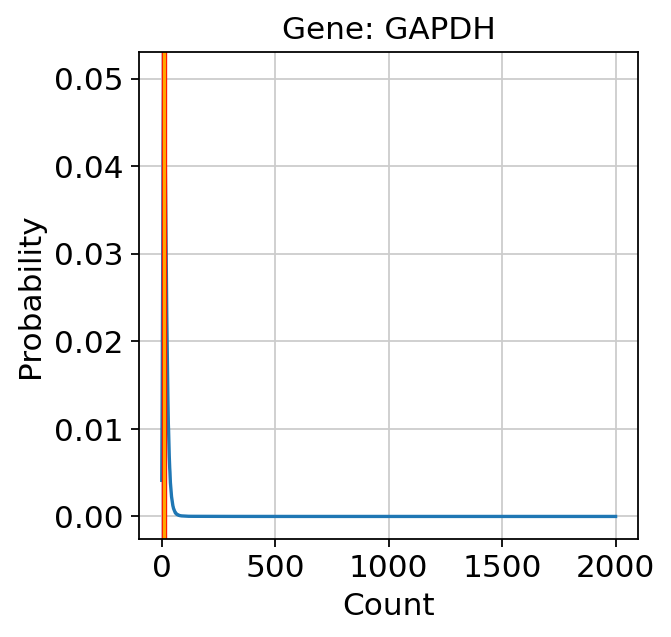

In [76]:
gene_symbol = 'GAPDH'
q = ctx.var_name_to_index_map[ctx.gene_symbol_to_gene_id_map[gene_symbol]]

print(f"mode: {gex_range_dict['gene_logits_mode_q'][q].item()}, range: {gex_range_dict['range_q'][q].item()}")
print(f"lo: {gex_range_dict['x_lo_q'][q].item()}, hi: {gex_range_dict['x_hi_q'][q].item()}")

query_id = query_gene_ids[q]
gene_symbol = ctx.gene_id_to_gene_symbol_map[query_id]

fig, ax = plt.subplots()

ax.plot(
    np.arange(max_counts),
    gex_range_dict['gene_logits_qk'][q].exp().cpu().numpy(), '-')
ax.axvline(gex_range_dict['x_lo_q'][q].item(), color='red')
ax.axvline(gex_range_dict['x_hi_q'][q].item(), color='red')
ax.axvline(gex_range_dict['gene_logits_mode_q'][q].item(), color='orange')

ax.set_title(f"Gene: {gene_symbol}")
ax.set_xlabel("Count")
ax.set_ylabel("Probability")

# ax.set_xlim((0, 10))

In [37]:
gene_logits_qk = gex_range_dict['gene_logits_qk']
gene_logits_mode_q = gex_range_dict['gene_logits_mode_q']
gene_marginal_mean_q = gex_range_dict['gene_marginal_mean_q']
gene_marginal_std_q = gex_range_dict['gene_marginal_std_q']
gene_logits_mode_q = gex_range_dict['gene_logits_mode_q']
range_q =  gex_range_dict['range_q']
x_lo_q = gex_range_dict['x_lo_q']
x_hi_q = gex_range_dict['x_hi_q']

# let's pick genes to perturb (and query) that make sense for this cell type
expr_threshold_tpm = 0.1
expr_threshold_mean = expr_threshold_tpm * total_mrna_umis / 1e6
expressed_mask_q = (gene_marginal_mean_q >= expr_threshold_mean).cpu().numpy()

filtered_query_gene_ids = query_gene_ids[expressed_mask_q]
filtered_perturb_gene_ids = query_gene_ids[expressed_mask_q]
filtered_query_gene_symbols = [ctx.gene_id_to_gene_symbol_map[gid] for gid in filtered_query_gene_ids]
filtered_perturb_gene_symbols = [ctx.gene_id_to_gene_symbol_map[gid] for gid in filtered_perturb_gene_ids]
filtered_x_lo_q = x_lo_q.cpu().numpy()[expressed_mask_q]
filtered_x_hi_q = x_hi_q.cpu().numpy()[expressed_mask_q]

print("Number of genes to perturb:", len(filtered_perturb_gene_ids))
print("Number of genes to query:", len(filtered_query_gene_ids))

Number of genes to perturb: 19187
Number of genes to query: 19187


In [79]:
n_points = 5
query_chunk_size = 64

dose_response_dict = ctx.generate_gene_dose_response_for_metadata(
    assay=assay,
    suspension_type=suspension_type,
    prompt_metadata_dict=prompt_metadata_dict,
    total_mrna_umis=total_mrna_umis,
    query_gene_ids=filtered_query_gene_ids,
    perturb_gene_ids=filtered_perturb_gene_ids,
    x_lo_p=filtered_x_lo_q,
    x_hi_p=filtered_x_hi_q,
    n_points=n_points,
    query_chunk_size=query_chunk_size,
    max_counts=max_counts,
)

Processing dose quantiles:   0%|          | 0/5 [00:00<?, ?it/s]

Processing query gene chunks:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
# import pickle

# with open('/home/mehrtash/data/cd8_dose_response_dict_tpm_0.1.pkl', 'wb') as f:
#     pickle.dump(dose_response_dict, f)

In [38]:
import pickle

with open('/home/mehrtash/data/cd8_dose_response_dict_tpm_0.1.pkl', 'rb') as f:
    dose_response_dict = pickle.load(f)

In [39]:
dose_response_dict.keys()

dict_keys(['doses_pi', 'responses_mean_pqi', 'responses_std_pqi', 'control_mean_q', 'control_std_q'])

In [40]:
for i, gene_id in enumerate(filtered_query_gene_ids):
    print(i, filtered_query_gene_symbols[i])

0 SDF4
1 ENSG00000272106
2 FAAP20
3 DRAXIN
4 MTHFR
5 CLCN6
6 TNFRSF8
7 IFFO2
8 UBXN10
9 HSPG2
10 ZNF436
11 RCAN3AS
12 FABP3
13 HPCA
14 ENSG00000286899
15 EPHA10
16 EXO5-DT
17 P3H1
18 ARMH1
19 STIL
20 SERBP1
21 PRKACB
22 CLCA1
23 GTF2B
24 LINC02609
25 MTF2
26 RWDD3-DT
27 HENMT1
28 PRPF38B
29 WDR47
30 CTSK
31 CRCT1
32 SPRR2D
33 DAP3
34 ARHGEF2
35 BGLAP
36 AIM2
37 UHMK1
38 ENSG00000287929
39 EDEM3
40 RABIF
41 PIK3C2B
42 ENSG00000260805
43 TAF1A-AS1
44 PYCR2
45 ACBD3
46 JMJD4
47 TMEM78
48 MTR
49 ENSG00000273175
50 KIF26B
51 LPIN1
52 DDX1
53 MYCN
54 FNDC4
55 VIT
56 NDUFAF7
57 VPS54
58 ENSG00000281195
59 ENSG00000279070
60 REG3G
61 POLR1A
62 MRPL35
63 IGKV2-40
64 IGKV3D-15
65 CHST10
66 TMEM182
67 SULT1C4
68 RGPD6
69 FBLN7
70 RAB3GAP1
71 TTC21B
72 NOSTRIN
73 PDE11A
74 ORMDL1
75 MAP2
76 PECR
77 ENSG00000236886
78 ANKZF1
79 ASIC4
80 SP100
81 MLPH
82 CAPN10-DT
83 ANO7
84 TADA3
85 ENSG00000272477
86 ACAA1
87 CTNNB1
88 ZNF197
89 TMEM42
90 SAMMSON
91 TOMM70
92 DUBR
93 ENSG00000241490
94 TMEM39A
95 

Text(0, 0.5, 'Response of GZMA')

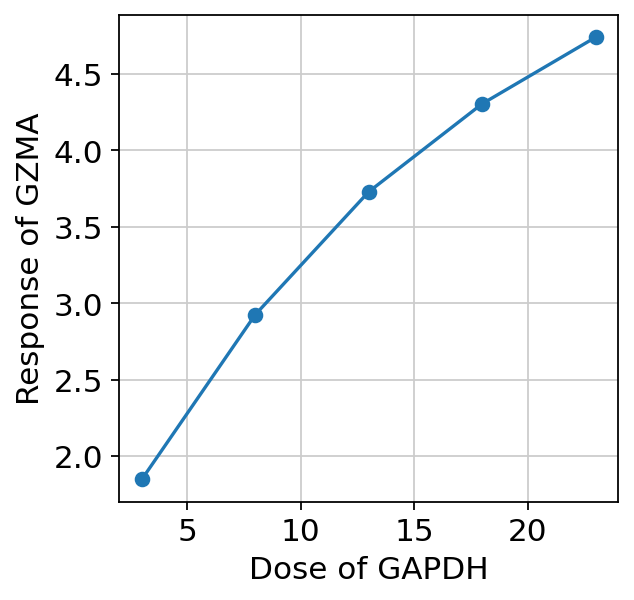

In [63]:
p = filtered_perturb_gene_symbols.index('GAPDH')
q = filtered_query_gene_symbols.index('GZMA')

fig, ax = plt.subplots()

ax.plot(dose_response_dict['doses_pi'][p, :], dose_response_dict['responses_mean_pqi'][p, q, :], marker='o')
ax.set_xlabel(f"Dose of {filtered_perturb_gene_symbols[p]}")
ax.set_ylabel(f"Response of {filtered_query_gene_symbols[q]}")

In [42]:
import numpy as np
from scipy.stats import linregress

def batch_linear_regression(x_bn, y_bn):
    """
    Perform batch-mode one-dimensional linear regression on data with arbitrary batch dimensions.
    
    For each batch (with indices b), we assume a linear model:
    
        y_bn = slope_b * x_bn + intercept_b + error_bn
    
    where:
      - x_bn and y_bn are arrays of shape (..., n), with the rightmost dimension (n) 
        representing the samples,
      - the leftmost dimensions (possibly several) are treated as batch dimensions.
    
    Parameters
    ----------
    x_bn : np.ndarray
        Array of covariates with shape (..., n).
    y_bn : np.ndarray
        Array of responses with shape (..., n).
        
    Returns
    -------
    slope_b : np.ndarray
        Array of slopes with shape equal to the batch shape.
        For any batch where the variance of x_bn is zero, the slope is set to 0.
    intercept_b : np.ndarray
        Array of intercepts with shape equal to the batch shape.
    r_squared_b : np.ndarray
        Array of R-squared values with shape equal to the batch shape.
        For any batch where the total variance of y_bn is zero, r_squared_b is defined as 1.
    """
    # Assert that inputs are numpy arrays of the same shape.
    assert isinstance(x_bn, np.ndarray), "x_bn must be a numpy array"
    assert isinstance(y_bn, np.ndarray), "y_bn must be a numpy array"
    assert x_bn.shape == y_bn.shape, "x_bn and y_bn must have the same shape"
    assert x_bn.ndim >= 1, "x_bn and y_bn must have at least one dimension (samples)"

    # Compute the means along the sample dimension (rightmost axis) and keep that dimension.
    # The resulting arrays have shape (..., 1) and are named with a '_b1' suffix.
    x_mean_b1 = np.mean(x_bn, axis=-1, keepdims=True)  # shape: (..., 1)
    y_mean_b1 = np.mean(y_bn, axis=-1, keepdims=True)  # shape: (..., 1)
    
    # Compute the covariance for each batch:
    #   cov_b = sum_n[(x_bn - x_mean_b1) * (y_bn - y_mean_b1)]
    cov_b = np.sum((x_bn - x_mean_b1) * (y_bn - y_mean_b1), axis=-1)  # shape: batch shape
    
    # Compute the variance of x for each batch:
    #   var_x_b = sum_n[(x_bn - x_mean_b1)^2]
    var_x_b = np.sum((x_bn - x_mean_b1)**2, axis=-1)  # shape: batch shape
    
    # Compute the slope for each batch, using np.divide to avoid division by zero.
    slope_b = np.divide(cov_b, var_x_b, out=np.zeros_like(cov_b), where=(var_x_b != 0))
    
    # Compute the intercept for each batch.
    intercept_b = y_mean_b1.squeeze(-1) - slope_b * x_mean_b1.squeeze(-1)
    
    # Compute the predicted responses for each batch:
    #   yhat_bn = slope_b * x_bn + intercept_b (broadcasting over the sample dimension)
    yhat_bn = slope_b[..., None] * x_bn + intercept_b[..., None]
    
    # Compute the residual sum of squares (SS_res) and total sum of squares (SS_tot) for each batch.
    ss_res_b = np.sum((y_bn - yhat_bn)**2, axis=-1)
    ss_tot_b = np.sum((y_bn - y_mean_b1)**2, axis=-1)
    
    # Compute R-squared for each batch. If ss_tot_b == 0, define R-squared as 1.
    r_squared_b = np.where(ss_tot_b != 0, 1 - ss_res_b / ss_tot_b, 1.0)
    
    return slope_b, intercept_b, r_squared_b

def test_batch_linear_regression():
    """
    Test the batch_linear_regression function by comparing its outputs with:
      1. Running each batch individually using scipy.stats.linregress.
      2. Ensuring that processing the batches together or one at a time yield the same results.
    """
    # Set a random seed for reproducibility.
    np.random.seed(0)
    
    # Define a batch shape (can be multidimensional) and number of samples.
    batch_shape = (3, 4)  # Two batch dimensions for demonstration.
    num_samples = 100     # Rightmost dimension: sample index.
    
    # Generate random covariate data with shape (3, 4, 100).
    x_bn = np.random.rand(*batch_shape, num_samples)
    
    # Define true slopes and intercepts for each batch.
    true_slopes = np.linspace(0.5, 2.0, num=np.prod(batch_shape)).reshape(*batch_shape, 1)
    true_intercepts = np.linspace(1.0, 3.0, num=np.prod(batch_shape)).reshape(*batch_shape, 1)
    
    # Generate responses with added noise.
    noise_bn = np.random.randn(*batch_shape, num_samples) * 0.1
    y_bn = true_intercepts + true_slopes * x_bn + noise_bn
    
    # Use our batch regression implementation.
    slope_b, intercept_b, r_squared_b = batch_linear_regression(x_bn, y_bn)
    
    # Now, compute the regression parameters one batch at a time using scipy.stats.linregress.
    # We'll flatten the batch dimensions for easier iteration.
    x_bn_flat = x_bn.reshape(-1, num_samples)
    y_bn_flat = y_bn.reshape(-1, num_samples)
    
    slopes_scipy = np.empty(x_bn_flat.shape[0])
    intercepts_scipy = np.empty(x_bn_flat.shape[0])
    r_squared_scipy = np.empty(x_bn_flat.shape[0])
    
    for i in range(x_bn_flat.shape[0]):
        x_n = x_bn_flat[i]
        y_n = y_bn_flat[i]
        result = linregress(x_n, y_n)
        slopes_scipy[i] = result.slope
        intercepts_scipy[i] = result.intercept
        r_squared_scipy[i] = result.rvalue**2  # R-squared is the square of the r-value.
    
    # Reshape the individual results to the original batch shape.
    slopes_scipy = slopes_scipy.reshape(batch_shape)
    intercepts_scipy = intercepts_scipy.reshape(batch_shape)
    r_squared_scipy = r_squared_scipy.reshape(batch_shape)
    
    # Assert that the batch regression results match the individual regressions.
    assert np.allclose(slope_b, slopes_scipy, atol=1e-6), "Slopes do not match between batch and individual regressions."
    assert np.allclose(intercept_b, intercepts_scipy, atol=1e-6), "Intercepts do not match between batch and individual regressions."
    assert np.allclose(r_squared_b, r_squared_scipy, atol=1e-6), "R-squared values do not match between batch and individual regressions."
    
    print("Test passed: Batch regression results match individual regressions and scipy.linregress results.")

In [43]:
n_query_vars = len(filtered_query_gene_ids)
n_perturb_vars = len(filtered_perturb_gene_ids)

doses_pi = dose_response_dict['doses_pi']
responses_mean_pqi = dose_response_dict['responses_mean_pqi']

slope_qp, intercept_qp, r_squared_qp = batch_linear_regression(
    x_bn=np.repeat(doses_pi[None, :, :], n_query_vars, axis=-3),
    y_bn=responses_mean_pqi.transpose(1, 0, 2)
)

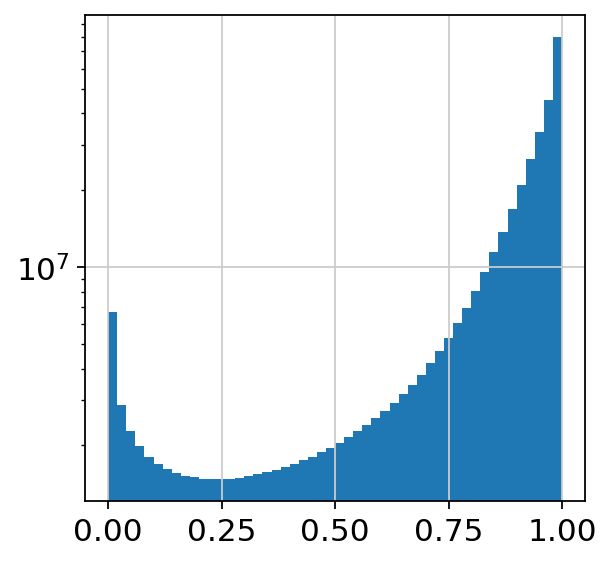

In [44]:
plt.hist(r_squared_qp.flatten(), bins=50, log=True);

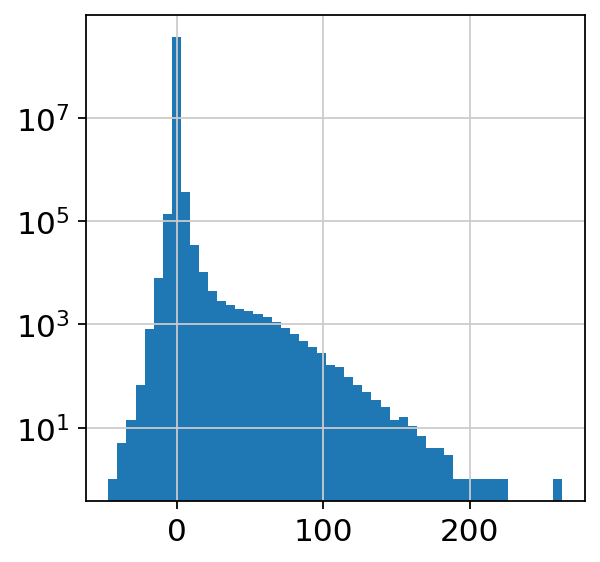

In [45]:
plt.hist(slope_qp.flatten(), bins=50, log=True);

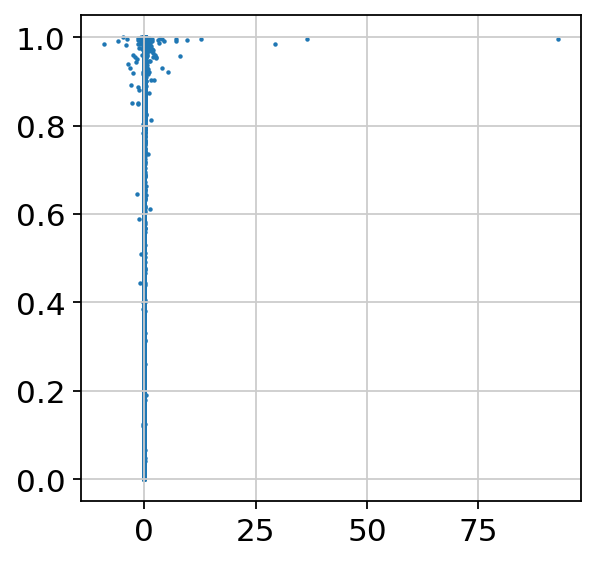

In [46]:
n_points = 10_000
size = slope_qp.shape[0] * slope_qp.shape[1]
rand_indices = np.random.permutation(size)[:n_points]
x = slope_qp.flatten()[rand_indices]
y = r_squared_qp.flatten()[rand_indices]
plt.scatter(x, y, s=1);

In [121]:
# Generate an AnnData containing just the metadata
adata_prop = sc.AnnData(
    X=np.zeros((1, 1)),
    obs=pd.DataFrame({
        "cell_type": [prompt_metadata_dict["cell_type"]],
        "tissue": [prompt_metadata_dict["tissue"]],
        "assay": [assay],
        "suspension_type": [suspension_type],
        "total_mrna_umis": [total_mrna_umis],
        "disease": "N/A",
        "development_stage": "N/A",
        "sex": "N/A",
    })
)

gene_info_tsv_path = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

response_qp = slope_qp.copy()
response_qp[r_squared_qp < 0.25] = 0.
prompt_marginal_mean_p = dose_response_dict["control_mean_q"]
prompt_marginal_std_p = dose_response_dict["control_std_q"]
query_marginal_mean_q = dose_response_dict["control_mean_q"]
query_marginal_std_q = dose_response_dict["control_std_q"]

network_ctx = GeneNetworkAnalysisBase(
    adata_obs=adata_prop.obs,
    gene_info_tsv_path=gene_info_tsv_path,
    query_var_names=filtered_query_gene_ids.tolist(),
    prompt_var_names=filtered_perturb_gene_ids.tolist(),
    response_qp=response_qp,
    prompt_marginal_mean_p=prompt_marginal_mean_p,
    prompt_marginal_std_p=prompt_marginal_std_p,
    query_marginal_mean_q=query_marginal_mean_q,
    query_marginal_std_q=query_marginal_std_q,
    verbose=True
)

In [122]:
network_ctx.process(
    response_normalization_strategy="mean",
    feature_normalization_strategy="z_score",
    feature_max_value=None,
    query_response_amp_min_pct=None,
    min_prompt_gene_tpm=0,
    min_query_gene_tpm=0,
    norm_pseudo_count=1e-3,
    query_hv_top_k=None,
    # z_trans_func=lambda x: 10. * np.tanh(0.1 * x)
)

2025-02-13 19:53:04,524 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Maximum value of z_qp: 87.419
2025-02-13 19:53:04,784 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Minimum value of z_qp: -192.053
2025-02-13 19:53:04,785 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Number of query genes after TPM filtering: 19187 / 19187
2025-02-13 19:53:04,786 - cellarium.ml.utilities.inference.cellarium_gpt_inference - INFO - Number of prompt genes after TPM filtering: 19187 / 19187


In [123]:
network_ctx.compute_adjacency_matrix(
    adjacency_strategy="positive_correlation",
    n_neighbors=50,
    beta=6.,
    self_loop=False)

In [124]:
i = network_ctx.prompt_gene_id_to_idx_map[network_ctx.gene_symbol_to_gene_id_map['CD3D']]
inds = np.argsort(network_ctx.a_pp[i, :])[::-1]
for j in inds[:100]:
    print(filtered_perturb_gene_symbols[j], network_ctx.a_pp[i, j])

CD52 0.1565533716449199
CD8A 0.1087066918919002
CD8B 0.09596716435108299
CORO1A 0.085173706945404
CD5 0.08301620381954343
CFL1 0.0726518930900382
IL32 0.07257330127816455
LPCAT4 0.07223186160228495
RPTOR 0.06968672203996511
HLA-A 0.0696851968356667
LINC00649 0.06890599868411967
BICDL1 0.06805181122968419
PDCD1 0.0672461223781432
TMSB10 0.06645898340367819
SIT1 0.06544472687329668
MCF2L2 0.06525994229800716
NSD2 0.06479313932293165
TBC1D19 0.06458169681690892
MT-ND4 0.06352731072653243
ARHGDIB 0.06309593824861949
ARHGAP35 0.06304704219006997
MT-ATP6 0.061960330263534265
CDCA8 0.061554303510713095
RPLP0 0.058425760957946056
TRANK1 0.057791098828607515
CDCA7 0.05756253213025655
CD70 0.05739751919045351
OGDH 0.057197951938705874
AUNIP 0.05630002280641244
MFHAS1 0.05567510097052668
SELENOI 0.05440760443460392
CEP192 0.05413910669041138
PPIA 0.05325518815138104
MT-CO2 0.05266676553479995
CCDC65 0.05199403065933024
LIN54 0.051130373537667695
SIRPG 0.05050659856859182
HNRNPLL 0.050476797463452

In [125]:
network_ctx.compute_leiden_communites(
    resolution=5.0)

In [126]:
len(np.unique(network_ctx.leiden_membership))

53

#### Embedding

In [127]:
import pymde

network_ctx.make_mde_embedding(
    n_neighbors=20,
    repulsive_penalty=pymde.penalties.Log,
    max_iter=1000,
    init="quadratic",
    device="cuda")

Feb 13 07:54:26 PM: Computing 20-nearest neighbors, with max_distance=None
Thu Feb 13 19:54:27 2025 Building RP forest with 17 trees
Thu Feb 13 19:54:33 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Feb 13 07:54:49 PM: Computing quadratic initialization.
Feb 13 07:54:53 PM: Fitting a centered embedding into R^2, for a graph with 19187 items and 1879564 edges.
Feb 13 07:54:53 PM: `embed` method parameters: eps=1.0e-05, max_iter=1000, memory_size=10
Feb 13 07:54:53 PM: iteration 0000 | distortion 4.361144 | residual norm 1.88672 | step length 0.00343867 | percent change 0.00331192
Feb 13 07:54:53 PM: iteration 0100 | distortion 0.158075 | residual norm 0.000127348 | step length 1 | percent change 0.7543
Feb 13 07:54:54 PM: iteration 0200 | distortion 0.154176 | residual norm 4.83483e-05 | step length 1 | percent change 0.204841
Feb 13 07:54:55 PM: iteration 0300 | distortion 0.153371 | residual norm 3.4

In [128]:
def get_gene_familities(network_ctx: GeneNetworkAnalysisBase, prefix_list: list[str]) -> tuple[list[str], list[str]]:
    _gene_symbols = [gene_symbol for prefix in prefix_list for gene_symbol in network_ctx.prompt_gene_symbols if gene_symbol.startswith(prefix)]
    gene_ids = [network_ctx.gene_symbol_to_gene_id_map[gene_symbol] for gene_symbol in _gene_symbols]
    gene_symbols = [network_ctx.gene_id_to_gene_symbol_map[gene_id] for gene_id in gene_ids]
    return gene_ids, gene_symbols

mito_gene_ids, mito_gene_symbols = get_gene_familities(network_ctx, ["MT-"])
ribo_gene_ids, ribo_gene_symbols = get_gene_familities(network_ctx, ["RPS", "RPL"])
hla_gene_ids, hla_gene_symbols = get_gene_familities(network_ctx, ["HLA"])
ifi_gene_ids, ifi_gene_symbols = get_gene_familities(network_ctx, ["IFI"])
trav_gene_ids, trav_gene_symbols = get_gene_familities(network_ctx, ["TRAV"])
hb_gene_ids, hb_gene_symbols = get_gene_familities(network_ctx, ["HBA", "HBB"])

highlight_gene_sets = {
    "Mito": (mito_gene_ids, mito_gene_symbols, 'red'),
    "Ribo": (ribo_gene_ids, ribo_gene_symbols, 'blue'),
    "HLA": (hla_gene_ids, hla_gene_symbols, 'green'),
    "IFI": (ifi_gene_ids, ifi_gene_symbols, 'orange'),
    "TRAV": (trav_gene_ids, trav_gene_symbols, 'purple'),
    "HB": (hb_gene_ids, hb_gene_symbols, 'black'),
}

# disable
# highlight_gene_sets = None

In [129]:
network_ctx.plot_mde_embedding(highlight_gene_sets=highlight_gene_sets)